In [125]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy as sp
import datetime
import matplotlib.pylab as plt
import os
import seaborn as sbn
from scipy.stats import norm
from scipy.stats import lognorm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime
from dateutil import relativedelta
from scipy.optimize import fsolve

In [126]:
class BSM:
    def __init__(self,Call,S,K,V,T,R,Q,Long,N,TP):
        self.Call=Call
        self.S=S  #asset price
        self.K=K  #strike 
        self.V=V  #Volatility
        self.T=T  #time to expiry
        self.R=R  #risk free rate
        self.Q=Q  #divdient yield/cash inflows
        self.Long=Long
        self.N=N   #Number of lots
        self.TP=TP #Traded price
        self.d1=(np.log(self.S/self.K)+(self.R-self.Q+(self.V**2)*0.5)*self.T)/(self.V*np.sqrt(self.T))
        self.d2=(np.log(self.S/self.K)+(self.R-self.Q-(self.V**2)*0.5)*self.T)/(self.V*np.sqrt(self.T))
        
        self.C=(self.S*np.exp(-self.Q*self.T)*norm.cdf(self.d1))-(self.K*np.exp(-self.R*self.T)*norm.cdf(self.d2))
        self.P=(self.K*np.exp(-self.R*self.T)*norm.cdf(-self.d2))-(self.S*np.exp(-self.Q*self.T)*norm.cdf(-self.d1))
        
        self.deltac=np.exp(-self.Q*self.T)*norm.cdf(self.d1)
        self.thetac=-(self.S*np.exp(-self.Q*self.T)*norm.pdf(self.d1)*self.V*0.5/np.sqrt(self.T))-(self.R*self.K*np.exp(-self.R*self.T)*norm.cdf(self.d2))+(self.Q*self.S*np.exp(-self.Q*self.T)*norm.cdf(self.d1))
        self.thetap=-(self.S*np.exp(-self.Q*self.T)*norm.pdf(self.d1)*self.V*0.5/np.sqrt(self.T))+(self.R*self.K*np.exp(-self.R*self.T)*norm.cdf(-self.d2))-(self.Q*self.S*np.exp(-self.Q*self.T)*norm.cdf(-self.d1))
        self.gammac=np.exp(-self.Q*self.T)*norm.pdf(self.d1)/(self.S*self.V*np.sqrt(self.T))
        self.vegac=(self.S*np.exp(-self.Q*self.T)*np.sqrt(self.T)*norm.pdf(self.d1))/100
        
    def price(self):
        if self.Call:
            return self.C
        else:
            return self.P
    
    def delta(self):
        if self.Long: 
            if self.Call:
                return self.deltac*self.N
            else:
                return (self.deltac-np.exp(-self.Q*self.T))*self.N
        else:
            if self.Call:
                return -(self.deltac)*self.N
            else:
                return -(self.deltac-np.exp(-self.Q*self.T))*self.N
        
    def gamma(self):
        if self.Long: 
            if self.Call:
                return self.gammac*self.N
            else:
                return -self.gammac*self.N
        else:
            if self.Call:
                return -(self.gammac)*self.N
            else:
                return (self.gammac)*self.N
    
    def theta(self):
        if self.Long: 
            if self.Call:
                return self.thetac*self.N/365
            else:
                return self.thetap*self.N/365
        else:
            if self.Call:
                return -(self.thetac*self.N/365)
            else:
                return -(self.thetap*self.N/365)
    
    def vega(self):
        if self.Long: 
            return self.vegac*self.N
        else:
            return -self.vegac*self.N
    
    def payoff(self):
        if self.Long:
            if self.Call:
                return np.maximum(self.S-self.K,-self.TP)
            else:
                return np.maximum(self.K-self.S,-self.TP)
        else:
            if self.Call:
                return np.minimum(self.TP,self.TP-(self.S-self.K))
            else:
                return np.minimum(self.TP,self.TP-(self.K-self.S))
    
        

In [135]:
def Barrier_Option(S0,H,K,T,r,q,vol,Option,Optiontype):
    #S0= asset price
    #H = Barrier
    #K = strike
    #T= time to expiry
    #r = risk free rate
    #q = dividend yield
    #vol= volatility
    #Option = Call=1/Put=0
    #Optiontype = Barrier type (Up&out, down&out, Up&in, down&in)
      
    lambda_=(r-q+(vol**2)/2)/(vol**2)
    y=(np.log((H**2)/(S0*K))/(vol*np.sqrt(T)))+lambda_*vol*(T**0.5)
    x1 = (np.log(S0/H)/(vol*T**0.5)) + lambda_*vol*(T**0.5)
    y1=  (np.log(H/S0)/(vol*T**0.5)) + lambda_*vol*(T**0.5)
    BSM_Call=BSM(1,S0,K,vol,T,r,q,True,1,100)
    BSM_Put=BSM(0,S0,K,vol,T,r,q,True,1,100)

    if Option==1:
        if S0<H:
            if H<=K:
                Call_do=0
                Call_di = BSM_Call.price()
                Call_uo=0
                Call_ui=BSM_Call.price()
            elif H>K:
                Call_do = 0
                Call_di=BSM_Call.price()-Call_do
                Call_ui = (S0*norm.cdf(x1)*np.exp(-q*T) - K*np.exp(-r*T)*norm.cdf(x1-vol*(T**0.5)) - 
                           S0*np.exp(-q*T)*((H/S0)**(2*lambda_))*(norm.cdf(-y)-norm.cdf(-y1)) + 
                           K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*(norm.cdf(-y+vol*T**0.5) - norm.cdf(-y1+vol*T**0.5)))
                Call_uo=BSM_Call.price() - Call_ui
        
        elif S0>=H:
            if H<=K:
                Call_di = (S0*np.exp(-q*T)*((H/S0)**(2*lambda_))*norm.cdf(y)  -  
                           K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*norm.cdf(y-vol*(T**0.5)))
                Call_do = BSM_Call.price()-Call_di
                Call_uo = 0
                Call_ui = BSM_Call.price()
            elif H>K:
                Call_do = (S0*norm.cdf(x1)*np.exp(-q*T) - K*np.exp(-r*T)*norm.cdf(x1-vol*T**0.5) - 
                           S0*np.exp(-q*T)*((H/S0)**(2*lambda_))*norm.cdf(y1) + 
                           K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*norm.cdf(y1-vol*T**0.5))
                Call_di=BSM_Call.price()-Call_do
                Call_ui = (S0*norm.cdf(x1)*np.exp(-q*T) - K*np.exp(-r*T)*norm.cdf(x1-vol*(T**0.5)) - 
                           S0*np.exp(-q*T)*((H/S0)**(2*lambda_))*(norm.cdf(-y)-norm.cdf(-y1)) + 
                           K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*(norm.cdf(-y+vol*T**0.5) - norm.cdf(-y1+vol*T**0.5)))
                Call_uo=0
        
    elif Option==0:
        if S0<H:
            if H<=K:
                Put_di=(-S0*norm.cdf(-x1)*np.exp(-q*T) + K*np.exp(-r*T)*norm.cdf(-x1+vol*T**0.5) + 
                        S0*np.exp(-q*T)*((H/S0)**(2*lambda_))*(norm.cdf(y)-norm.cdf(y1)) - 
                        K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*(norm.cdf(y-vol*T**0.5) - norm.cdf(y1-vol*T**0.5)))
                Put_do=0
                Put_uo= (-S0*norm.cdf(-x1)*np.exp(-q*T) + K*np.exp(-r*T)*norm.cdf(-x1+vol*T**0.5) + 
                         S0*np.exp(-q*T)*((H/S0)**(2*lambda_))*(norm.cdf(-y1)) - 
                         K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*(norm.cdf(-y1+vol*T**0.5)))
                Put_ui=BSM_Put.price() - Put_uo
            elif H>K: 
                Put_do = 0
                Put_di=BSM_Put.price()
                Put_ui = (-S0*norm.cdf(-y)*np.exp(-q*T)*((H/S0)**(2*lambda_)) + 
                          K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*(norm.cdf(-y+vol*T**0.5)) )
                Put_uo = BSM_Put.price() - Put_ui
        elif S0>=H:
            if H<=K:
                Put_di=(-S0*norm.cdf(-x1)*np.exp(-q*T) + K*np.exp(-r*T)*norm.cdf(-x1+vol*T**0.5) + 
                        S0*np.exp(-q*T)*((H/S0)**(2*lambda_))*(norm.cdf(y)-norm.cdf(y1)) - 
                        K*np.exp(-r*T)*((H/S0)**(2*lambda_-2))*(norm.cdf(y-vol*T**0.5) - norm.cdf(y1-vol*T**0.5)))
                Put_do=BSM_Put.price()-Put_di
                Put_uo= 0
                Put_ui=BSM_Put.price() - Put_uo
            elif H>K: 
                Put_do = 0
                Put_di=BSM_Put.price()
                Put_ui = BSM_Put.price()
                Put_uo = 0
    
    
    if Optiontype== "UI" and Option==1:
        return Call_ui
    elif Optiontype == "UO" and Option==1:
        return Call_uo
    elif Optiontype == "DI" and Option==1:
        return Call_di
    elif Optiontype == "DO" and Option==1:
        return Call_do
    elif Optiontype == "UI" and Option==0:
        return Put_ui
    elif Optiontype == "UO" and Option==0:
        return Put_uo
    elif Optiontype == "DI" and Option==0:
        return Put_di
    elif Optiontype == "DO" and Option==0:
        return Put_do

In [144]:
Barrier_Option(54,60,55,5/12,0.1,0,0.4,0,"DI")

4.882942250253397

In [137]:
def delta_barrier(S0,H,K,T,r,q,vol,Option,Optiontype):
    delta_option=Barrier_Option(S0*1.0001,H,K,T,r,q,vol,Option,Optiontype)-Barrier_Option(S0,H,K,T,r,q,vol,Option,Optiontype)
    delta_S=S0*1.0001-S0
    delta=delta_option/delta_S
    return delta

In [146]:
delta_barrier(54,60,55,5/12,0.1,0,0.4,0,"DI")

-0.41309076784670773

In [139]:
def gamma_barrier(S0,H,K,T,r,q,vol,Option,Optiontype):
    delta_option=delta_barrier(S0*1.0001,H,K,T,r,q,vol,Option,Optiontype)-delta_barrier(S0,H,K,T,r,q,vol,Option,Optiontype)
    delta_S=S0*1.0001-S0
    gamma=delta_option/delta_S
    return gamma

In [147]:
gamma_barrier(54,60,55,5/12,0.1,0,0.4,0,"DI")

0.027928644406780948

In [148]:
def gamma_barrier_chart(S0,H,K,T,r,q,vol,Option,Optiontype):
    gamma_list=[]
    prices=[x for x in np.arange(round(S0*0.95,1),round(S0*1.05,1),0.1)]
    for i in range(0,len(prices)-1):
        gamma_list.append(gamma_barrier(prices[i],H,K,T,r,q,vol,Option,Optiontype))
    return list(zip(prices,gamma_list))

No handles with labels found to put in legend.


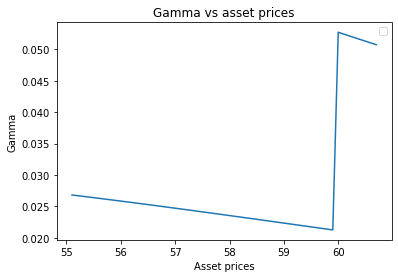

In [149]:
plt.plot([x[0] for x in gamma_barrier_chart(58,60,55,5/12,0.1,0,0.4,1,"DI")],[x[1] for x in gamma_barrier_chart(58,60,55,5/12,0.1,0,0.4,1,"DI")])
plt.title('Gamma vs asset prices')
plt.ylabel('Gamma')
plt.xlabel('Asset prices')
plt.legend()
plt.show()